In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")
from pylab import rcParams
import seaborn as sns
%matplotlib inline
np.random.seed(27)
rcParams['figure.figsize'] = 10, 6
sns.set(style="darkgrid")
from sklearn.model_selection import train_test_split, KFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import nltk
import re
import unicodedata
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import string
nltk.download('stopwords')
nltk.download('punkt')
stopwords_ = set(stopwords.words('english'))
punctuation_ = set(string.punctuation)

from nltk.stem.snowball import SnowballStemmer
stemmer_snowball = SnowballStemmer('english')

from nltk.stem.porter import PorterStemmer
stemmer_porter = PorterStemmer()
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer




[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shwetasharma1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shwetasharma1/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [179]:
# diet column has more than half nans. will not be using it.
#income had many negative values. dropping tyhis column as well
# users_no_na.groupby(["ethnicity"]).size()

# users = pd.read_csv("./data/profiles.csv")
df = pd.read_csv("./users_essay")
# users_no_na = users[users["drugs"].notna()]


In [180]:
users_no_na["essay"] = users_no_na["essay0"] + users_no_na["essay1"] + users_no_na["essay2"] + users_no_na["essay3"] + users_no_na["essay4"] + users_no_na["essay5"] + users_no_na["essay6"] + users_no_na["essay7"] + users_no_na["essay8"] + users_no_na["essay9"]

NameError: name 'users_no_na' is not defined

## preprocessing for NLP

In [ ]:
def clean_text(text):
    '''
    clean the text data: split the text, remove the redundant signs and words.
    '''
    text = text.replace('<br />', ' ')
    text = text.replace('\n', ' ')
    words = nltk.word_tokenize(text)   #split the text into words
    words = [word for word in words if word.isalpha()]    #remove the non-alphabetic signs
    stop_words = stopwords.words('english')
    words = [word for word in words if word not in set(stop_words)]   #remove the stop words
    return words

def clean_text_column(df, col_name):
    '''
    input a dataframe and one of its column, the function clean the text within
    the column.
    '''
    df_ = df[df[col_name].notnull()]
    df[col_name] = df_.apply(lambda row: clean_text(row[col_name]), axis = 1)

In [ ]:

def remove_accents(input_str):
    '''
    This function is to remove the accents
    '''
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    only_ascii = nfkd_form.encode('ASCII', 'ignore')
    return only_ascii.decode()

def remove_http(sentences):
    '''
    remove the URLs in the text
    '''
    sentences_ = []
    for sentence in sentences:
        sentence = re.sub(r"http\S+", "", sentence)
        sentences_.append(sentence)
    return [sent for sent in sentences_ if not sent in {"", "'"}]

def filter_tokens(sentence):
    '''
    This is to remove the stop words. Update the stop words in set stopwords2
    '''
    stopwords1 = set(stopwords.words('english'))
    stopwords2 = {"\'s","\'ve","\'re", "n't", 'INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
                  'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ', 'infj', 'entp','intp','intj',
                  'entj','enfj','infp', 'enfp','isfp','istp','isfj','istj','estp','esfp','estj','esfj'}
    stopwords_ = stopwords1.union(stopwords2)
    
    punctuation_ = set(string.punctuation)
    return([w for w in sentence if not w in stopwords_ and not w in punctuation_])

def remove_digits(sentences):
    '''
    remove the numbers in the text
    '''
    sentences_ = []
    for sentence in sentences:
        sentence = re.sub(r'[^a-zA-Z]+', ' ', sentence)
        sentences_.append(sentence)
    return [sent for sent in sentences_ if not sent in {"", "'"}]

def lemm_and_stem(sentences):
    '''
    lemmatizing and stemming the words
    '''
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    
    output = []
    for word_list in sentences:
        lemmatized_words = [lemmatizer.lemmatize(w) for w in word_list]
        stemmed_words = ' '.join([stemmer.stem(w) for w in lemmatized_words])
        output.append(stemmed_words)
    return output

In [ ]:
def clean_data(input_str):
    accent_removed=remove_accents(input_str) #remove the accent
    sentences = accent_removed.split('|||') #split the string and get sentences
    removed_http = remove_http(sentences)
    removed_digits = remove_digits(removed_http)
    tokens = [sent for sent in map(word_tokenize, removed_digits)]
    tokens_lower = [[word.lower() for word in sentence]
                 for sentence in tokens]
    
    tokens_filtered = list(map(filter_tokens, tokens_lower))
    tokens_lemms = lemm_and_stem(tokens_filtered)

    return tokens_lemms



In [168]:
def run_model(estimator, X, y):
    kf = KFold(n_splits=5, shuffle=True)
    
    acc = []
    f1 = []
    for train_idx, test_idx in kf.split(X):
        X_train = X[train_idx]
        y_train = y[train_idx]
         
        
        X_test = X[test_idx]
        y_test = y[test_idx]

        # data prep
        
        estimator.fit(X_train, y_train)
        y_preds = estimator.predict(X_test)
        acc.append(accuracy_score(y_test, y_preds))
        f1.append(f1_score(y_test, y_preds))
    
    generate_model_report(y_test, y_preds)
        
    plt.plot(range(0, 5), f1, label=estimator.__class__.__name__)

In [189]:
def generate_model_report(y_actual, y_predicted):
    print('Accuracy: %.3f' % accuracy_score(y_actual, y_predicted))
    print('Precision: %.3f' % precision_score(y_actual, y_predicted))
    print( 'Recall: %.3f' % recall_score(y_actual, y_predicted))
    print('F1 score: %.3f' % f1_score(y_actual, y_predicted))


In [ ]:
clean_text_column(users_no_na, 'essay')
users_no_na["essay"] = users_no_na["essay"].apply(lambda x: ", ".join(x))
 

In [ ]:
users_no_na["essay"]=  users_no_na["essay"].apply(lambda x: clean_data(x))

In [ ]:
users_no_na["essay"] = users_no_na["essay"].apply(lambda x: x[0] if x !=[] else "")

In [ ]:
users_no_na = pd.DataFrame(users_no_na)

In [ ]:
users_no_na.to_csv("users_essay") 

In [181]:
# rf_data = df[["age", "drinks", "education", "ethnicity", "orientation", "sex", "smokes", "religion", "drugs", "essay"]]
rf_data = df[["age","drinks","smokes", "drugs"]]

rf_data["drugs"] = rf_data["drugs"].replace(["never","sometimes", "often"], [0,1,1])

/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [182]:
#treating nans
rf_data["drinks"] = rf_data["drinks"].fillna("not at all")
rf_data["smokes"] = rf_data["smokes"].fillna("no")
# rf_data["smokes"] = rf_data["smokes"].fillna(" ")

/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/shwetasharma1/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [183]:
# cleaned_rf_data = rf_data[["age", "drinks", "education", "ethnicity", "orientation", "sex", "smokes", "religion", "drugs"]]

cleaned_rf_data = rf_data[["age", "drinks", "smokes", "drugs"]]
cleaned_rf_data_dummified = pd.get_dummies(cleaned_rf_data)



In [184]:
X_rf = cleaned_rf_data_dummified.loc[:,cleaned_rf_data_dummified.columns != "drugs"]


y_rf = cleaned_rf_data_dummified.loc[:,cleaned_rf_data_dummified.columns == "drugs"]

In [185]:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size = .10, random_state=1)

In [186]:
# Class count
count_class_0, count_class_1 = cleaned_rf_data_dummified['drugs'].value_counts()

rf_class_0 = cleaned_rf_data_dummified[cleaned_rf_data_dummified['drugs'] == 0]
rf_class_1 = cleaned_rf_data_dummified[cleaned_rf_data_dummified['drugs'] == 1]

Random over-sampling:
1    37724
0    37724
Name: drugs, dtype: int64


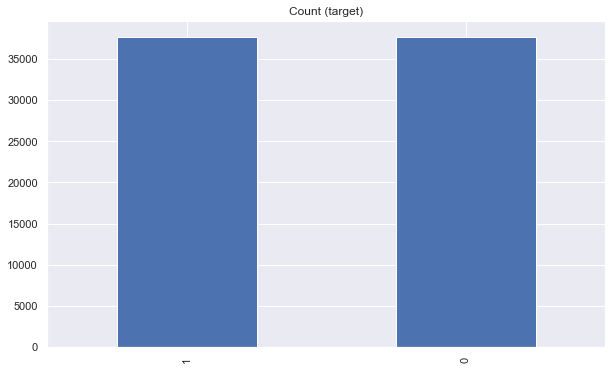

In [187]:
rf_class_1_over = rf_class_1.sample(count_class_0, replace=True)
rf_test_over = pd.concat([rf_class_0, rf_class_1_over], axis=0)

print('Random over-sampling:')
print(rf_test_over["drugs"].value_counts())

rf_test_over["drugs"].value_counts().plot(kind='bar', title='Count (target)');

In [198]:
X_rf_over = rf_test_over.loc[:, rf_test_over.columns != "drugs"]
y_rf_over = rf_test_over.loc[:, rf_test_over.columns=="drugs"]
X_rf_over_train, X_rf_over_test, y_rf_over_train, y_rf_over_test = train_test_split(X_rf_over, y_rf_over["drugs"], test_size=0.10, random_state=1)


Accuracy: 0.698
Precision: 0.774
Recall: 0.566
F1 score: 0.654
Accuracy: 0.704
Precision: 0.770
Recall: 0.581
F1 score: 0.662


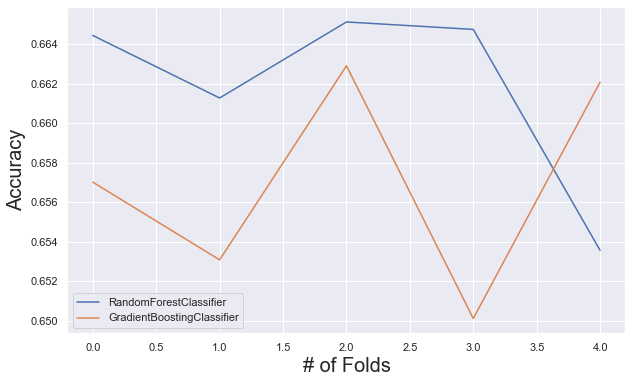

In [169]:
estimators = [RandomForestClassifier(), GradientBoostingClassifier()]
for estimator in estimators:
    run_model(estimator, X_rf_over_train.values, y_rf_over_train.values)
    
plt.ylabel('Accuracy', fontsize=20)
plt.xlabel('# of Folds', fontsize=20)
plt.legend()

In [197]:
model = RandomForestClassifier()
model.fit(X_rf_over_train, y_rf_over_train)
y_rf_over_preds = model.predict(X_rf_over_test)
generate_model_report(y_rf_over_test, y_rf_over_preds)

Accuracy: 0.704
Precision: 0.786
Recall: 0.562
F1 score: 0.655


In [199]:
y_final_preds = model.predict(X_rf_test)
generate_model_report(y_rf_test, y_final_preds)

Accuracy: 0.795
Precision: 0.426
Recall: 0.577
F1 score: 0.490


In [200]:
model = GradientBoostingClassifier()
model.fit(X_rf_over_train, y_rf_over_train)
y_final_preds = model.predict(X_rf_test)
generate_model_report(y_rf_test, y_final_preds)

Accuracy: 0.784
Precision: 0.408
Recall: 0.580
F1 score: 0.479


In [201]:
y_final_preds = model.predict(X_rf_test)
generate_model_report(y_rf_test, y_final_preds)

Accuracy: 0.784
Precision: 0.408
Recall: 0.580
F1 score: 0.479


In [ ]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : model.feature_importances_},
                           index=X_rf.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh')
plt.title('RF Feature Importances - MDI')

In [207]:
from sklearn.model_selection import GridSearchCV

def display_default_and_gsearch_model_results(model_default, model_gridsearch, 
                                              X_test, y_test):
    '''
        Parameters: model_default: fit model using initial parameters
                    model_gridsearch: fit model using parameters from gridsearch
                    X_test: 2d numpy array
                    y_test: 1d numpy array
        Return: None, but prints out mse and r2 for the default and model with
                gridsearched parameters
    '''
    name = model_default.__class__.__name__.replace('Classifier', '') # for printing
    y_test_pred = model_gridsearch.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    print("Results for {0}".format(name))
    print("Gridsearched model acc: {:0.3f}".format(acc))
    y_test_pred = model_default.predict(X_test)
    acc = accuracy_score(y_test, y_test_pred)
    print("     Default model acc: {:0.3f}".format(acc))
    
    
    
def gridsearch_with_output(estimator, parameter_grid, X_train, y_train):
    '''
        Parameters: estimator: the type of model (e.g. RandomForestRegressor())
                    paramter_grid: dictionary defining the gridsearch parameters
                    X_train: 2d numpy array
                    y_train: 1d numpy array
        Returns:  best parameters and model fit with those parameters
    '''
    model_gridsearch = GridSearchCV(estimator,
                                    parameter_grid,
                                    n_jobs=-1,
                                    verbose=True,
                                    scoring='accuracy')
    model_gridsearch.fit(X_train, y_train)
    best_params = model_gridsearch.best_params_ 
    model_best = model_gridsearch.best_estimator_
    print("\nResult of gridsearch:")
    print("{0:<20s} | {1:<8s} | {2}".format("Parameter", "Optimal", "Gridsearch values"))
    print("-" * 55)
    for param, vals in parameter_grid.items():
        print("{0:<20s} | {1:<8s} | {2}".format(str(param), 
                                                str(best_params[param]),
                                                str(vals)))
    return best_params, model_best




In [208]:
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, max_depth=2, random_state=1, max_features=1, verbose=0, max_leaf_nodes=None, warm_start=False, presort='deprecated', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)
gb.fit(X_rf_over_train, y_rf_over_train)
y_rf_over_preds = model.predict(X_rf_over_test)
generate_model_report(y_rf_over_test, y_rf_over_preds)




Accuracy: 0.700
Precision: 0.776
Recall: 0.564
F1 score: 0.654


In [209]:
y_final_preds = gb.predict(X_rf_test)
generate_model_report(y_rf_test, y_final_preds)

Accuracy: 0.785
Precision: 0.410
Recall: 0.583
F1 score: 0.482


In [210]:
rf = RandomForestClassifier()

In [211]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10, 20, 40, 80],
                      'random_state': [1]}
rf_best_params, rf_best_model = gridsearch_with_output(RandomForestClassifier(), 
                                                       random_forest_grid, 
                                                       X_rf_over_train, y_rf_over_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.4s


KeyboardInterrupt: 

In [212]:
rf = RandomForestClassifier(max_features="sqrt", min_samples_split=2, min_samples_leaf =1, bootstrap = True, n_estimators=10, random_state=1)

rf.fit(X_rf_over_train, y_rf_over_train)
y_rf_over_preds = model.predict(X_rf_over_test)
generate_model_report(y_rf_over_test, y_rf_over_preds)

Accuracy: 0.700
Precision: 0.776
Recall: 0.564
F1 score: 0.654


In [213]:
y_final_preds = rf.predict(X_rf_test)
generate_model_report(y_rf_test, y_final_preds)

Accuracy: 0.795
Precision: 0.427
Recall: 0.580
F1 score: 0.492
